### 1-Preparation of the data and definitions

This notebook we will import, analyse and prepare the data in order to be able to go to the next chapter, where we will perform GLM analysis.

- Author: Nesserine EL Mediouni

- Date:2024-08-27

- Kernel: R

Intermediate Agenda:
1. [Import Data](#import-data)  
2. [Descriptive Analysis](#descriptive-analysis)  
3. [Data Preparation](#data-preparation)  
4. [Error Functions](#error-functions)  
5. [Split training/test sets](#split-training-test-sets)  
6. [Split between attritional and atypical sets](#split-between-attritional-and-atypical-sets)  al sets

### 1.1 Import Data

In [2]:
#Import library you need

library(gmodels)    # Package which computes confidence intervals (we will use the function fit.contrast within this package)
library(car)        # Anova function (calculates type 2 or type 3 analysis-of-variance tables)
library(forcats)    # Package which facilitates the treatment of factors and their levels/modalities
library(Metrics)    # Contains some basic functions such as mse, rmse, mae...
library(caret)      # Useful package when doing Machine Learning / Pre-processing of data
library(ggplot2)    # To draw nice graphs

Le chargement a nécessité le package : carData

Le chargement a nécessité le package : ggplot2

Le chargement a nécessité le package : lattice


Attachement du package : 'caret'


Les objets suivants sont masqués depuis 'package:Metrics':

    precision, recall




In [4]:
# Import data file
Data<-read.csv("Data.csv", header=TRUE, sep=",", stringsAsFactors = TRUE)
head(Data)

,Age,RiskExp,NbrClaims,ClaimAmount,AgeCar,Sex,Fuel,Split,Use,Fleet,Sport,Cover,Power
,<int>,<dbl>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,64,1.00000000,0,0.0000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110
2,28,0.04657534,1,155.9746,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110
3,58,0.40273973,0,0.0000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66
4,37,0.16986301,0,0.0000,2-5,Female,Petrol,Once,Professional,No,No,MTPL+++,66-110
5,29,1.00000000,0,0.0000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66
6,25,0.29589041,0,0.0000,>10,Female,Petrol,Twice,Private,Yes,No,MTPL+,66-110


### 1.2 Descriptive Analysis

In this next section we will perform a descriptive analysis so you'll be able:

* to have a better overview of the data;
* to see the potential issues when importing the data;
* to have an idea of how the data are distributed according to each modality.
In order to do that, we will use a function which automatizes the process and automatically creates barplots.

In [5]:
Descriptive_Analysis <- function(DB,variable,output)
{
  lev <- levels(DB[[variable]])       # Which are the modalities of the variable
  number_Level <- length(lev)         # Number of modalities of the variable
  ER<- rep(0,number_Level)            # Risk exposure vector, with length the number of modalities
  NSin<- rep(0,number_Level)          # Number of claims according to each modality
  Claim_Fr<- rep(0,number_Level)
  Claim_Ch<- rep(0,number_Level)
  Average_Cost<- rep(0,number_Level)

  dataframe_ <- data.frame(Modalities = lev)
  dataframe_$Modalities <- factor(dataframe_$Modalities, levels = dataframe_$Modalities) # To keep the order of the modalities in the graph
  
  dataframe_$ER<-       # For each modality we compute the sum of Risk Exposure
  dataframe_$NSin <- tapply(DB[["NbrClaims"]],DB[[variable]],sum)      # For each modality we compute the total number of claims
  dataframe_$Claim_Ch <-tapply(DB[["ClaimAmount"]],DB[[variable]],sum)      # For each modality we compute the total charge resulting
  dataframe_$Claim_Fr <- dataframe_$NSin/dataframe_$ER
  dataframe_$Average_Cost <- dataframe_$Claim_Ch/dataframe_$NSin
    
  graph_results <- vector(mode = "list", length = 3)
  
  if (number_Level < 5)  # if more than 5 modalities, graphs are displayed horizontally (no more vertically)
  {
    lim <- floor(max(dataframe_$ER)*1.25)
    bp <- ggplot(data = dataframe_, aes_string(x = "Modalities", y = "ER", fill = "Modalities")) + geom_bar(stat="identity") + 
      ggtitle(paste("Sum of the Risk Exposure for variable", variable, sep=" ")) + ylim(0, lim)                       
    graph_results[[1]] <- bp
      
    
    lim <- (max(dataframe_$Claim_Fr)*1.25)
    bp <- ggplot(data = dataframe_, aes_string(x = "Modalities", y = "Claim_Fr", fill = "Modalities")) + geom_bar(stat="identity")  + 
      ggtitle(paste("Claim frequency for the variable", variable, sep=" ")) + ylim(0, lim)                      
    graph_results[[2]] <- bp
     
    
    lim <- floor(max(dataframe_$Average_Cost)*1.25)
    bp <- ggplot(data = dataframe_, aes_string(x = "Modalities", y = "Average_Cost", fill = "Modalities")) + geom_bar(stat="identity")  + 
      ggtitle(paste("Average Cost for variable", variable, sep=" ")) + ylim(0, lim)                                                  
    graph_results[[3]] <- bp
      

  } else
  {
    lim <- floor(max(dataframe_$ER)*1.25)
    bp <- ggplot(data = dataframe_, aes_string(x = "Modalities", y = "ER", fill = "Modalities")) + geom_bar(stat="identity") + 
      ggtitle(paste("Sum of the Risk Exposure for variable", variable, sep=" ")) + ylim(0, lim) + coord_flip()                      
    graph_results[[1]] <- bp
      
    
    lim <- (max(dataframe_$Claim_Fr)*1.25)
    bp <- ggplot(data = dataframe_, aes_string(x = "Modalities", y = "Claim_Fr", fill = "Modalities")) + geom_bar(stat="identity")  + 
      ggtitle(paste("Claim frequency for the variable", variable, sep=" ")) + ylim(0, lim) + coord_flip()                   
    graph_results[[2]] <- bp
     
    
    lim <- floor(max(dataframe_$Average_Cost)*1.25)
    bp <- ggplot(data = dataframe_, aes_string(x = "Modalities", y = "Average_Cost", fill = "Modalities")) + geom_bar(stat="identity")  + 
      ggtitle(paste("Average Cost for variable", variable, sep=" ")) + ylim(0, lim) + coord_flip()                                               
    graph_results[[3]] <- bp
  }
  return(graph_results)
}

Now we can use our function on all the explanatory variables included in our database:

In [6]:
graph_results <- vector(mode = "list", length = 1)
# Sex
graph_results[["Sex"]] <- Descriptive_Analysis(Data,"Sex")
# Use
graph_results[["Use"]] <- Descriptive_Analysis(Data,"Use")
# Fleet
graph_results[["Fleet"]] <- Descriptive_Analysis(Data,"Fleet")
# Sport
graph_results[["Sport"]] <- Descriptive_Analysis(Data,"Sport")
# Coverage
graph_results[["Cover"]] <- Descriptive_Analysis(Data,"Cover")
# Splitting up
graph_results[["Split"]] <- Descriptive_Analysis(Data,"Split")
# Fuel
graph_results[["Fuel"]] <- Descriptive_Analysis(Data,"Fuel")
# Age of the car
graph_results[["AgeCar"]] <- Descriptive_Analysis(Data,"AgeCar")
# Power of the car
graph_results[["Power"]] <- Descriptive_Analysis(Data,"Power")

Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information."


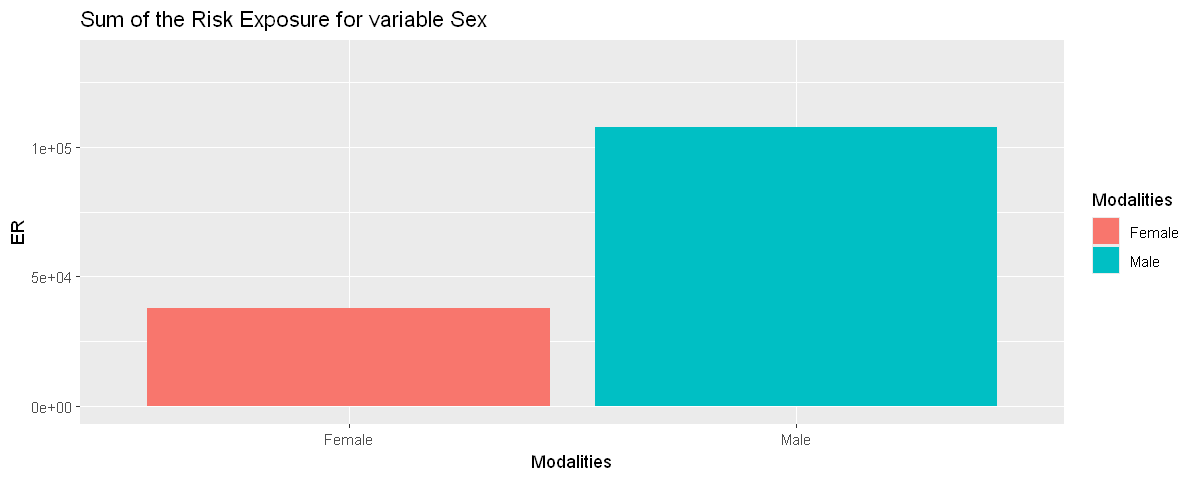

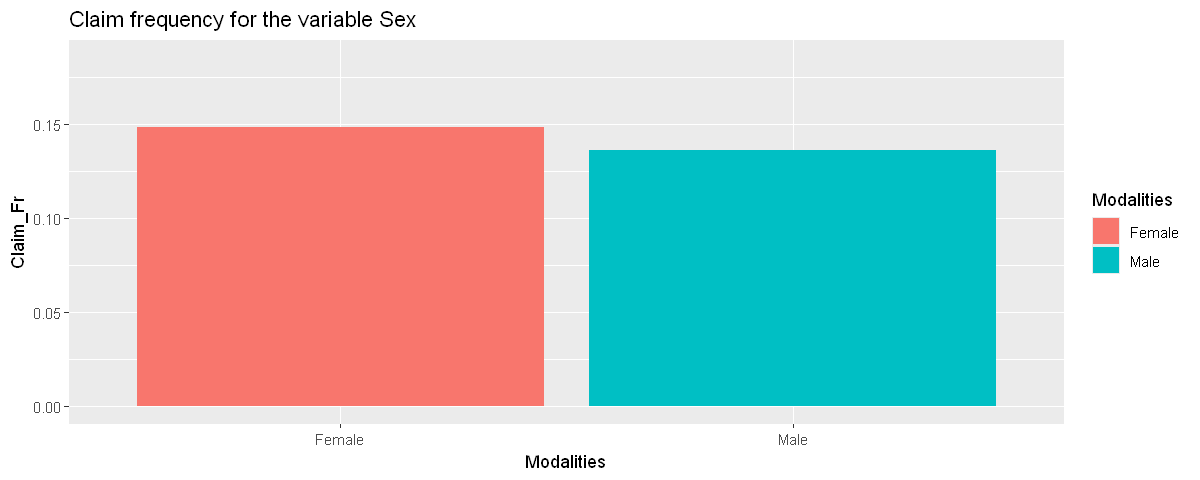

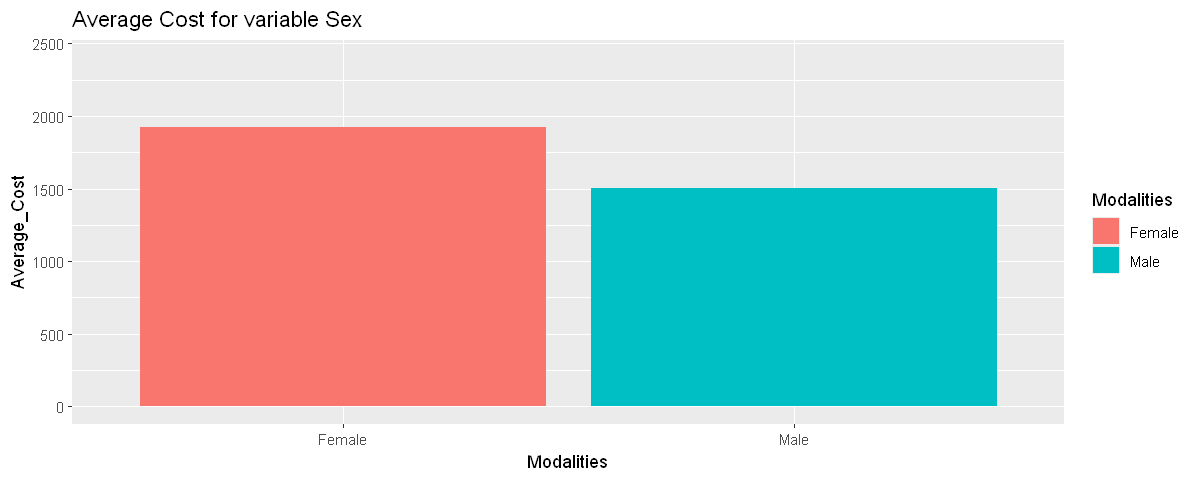

In [7]:
# Now we can print some of our statistics
options(repr.plot.width=10, repr.plot.height=4)    # To have a better display
print(graph_results[["Sex"]][[1]])  # For exposure
print(graph_results[["Sex"]][[2]])  # For claim frequency
print(graph_results[["Sex"]][[3]])  # For average claim amount

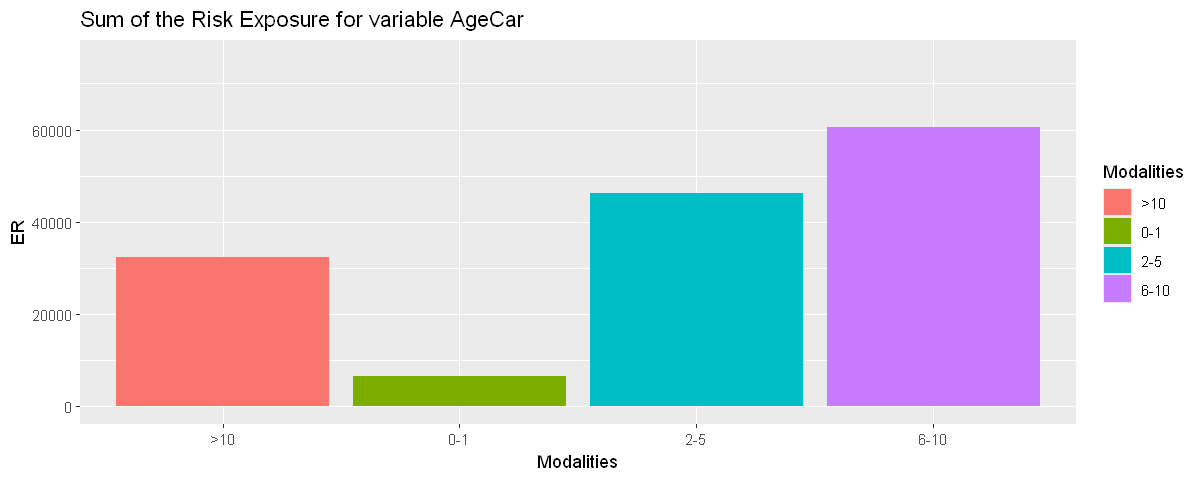

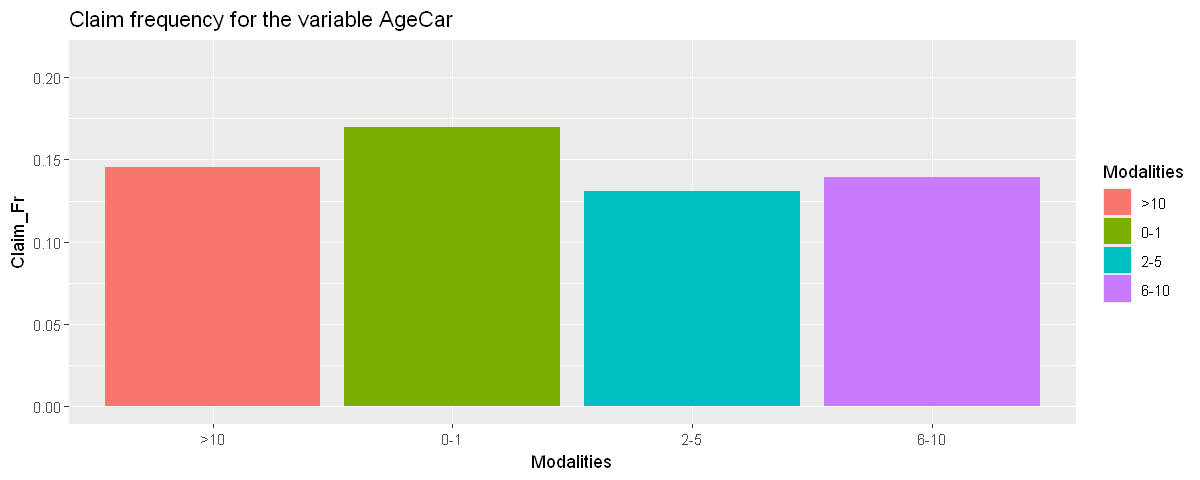

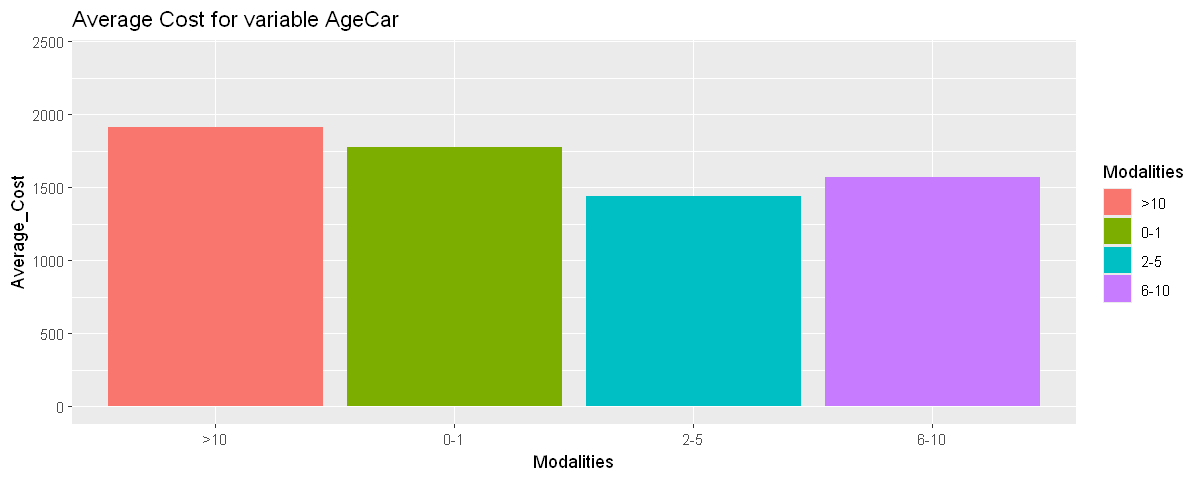

In [8]:
# Now we can print some of our statistics
print(graph_results[["AgeCar"]][[1]])  # For exposure
print(graph_results[["AgeCar"]][[2]])  # For claim frequency
print(graph_results[["AgeCar"]][[3]])  # For average claim amount

In [9]:
#As you can see, the display of the columns is not very logic. The modality ">= 10" should be displayed on the far right. So we are going to modify it in order to improve our graph's readability.
levels(Data$AgeCar)

[1] ">10"  "0-1"  "2-5"  "6-10"

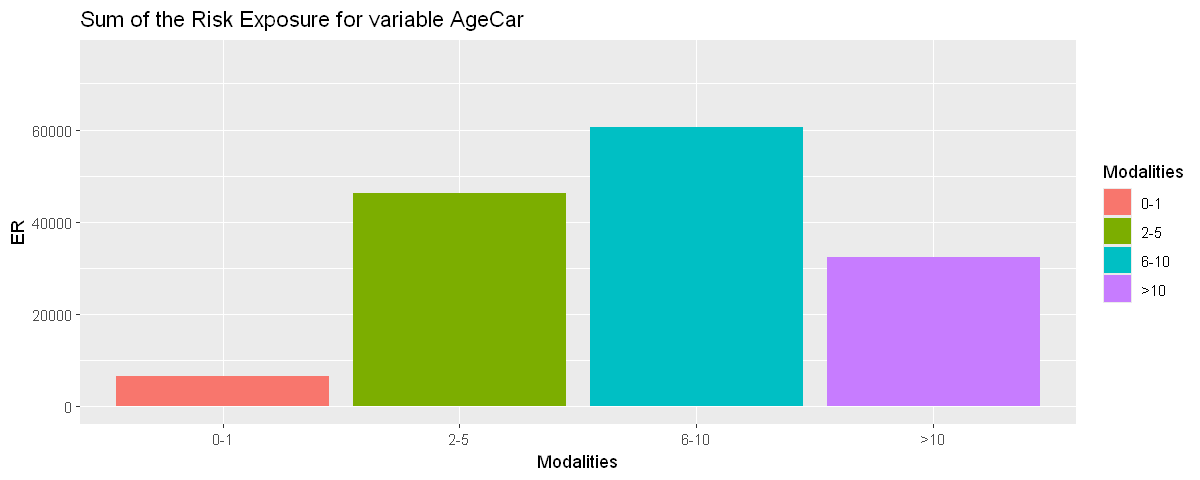

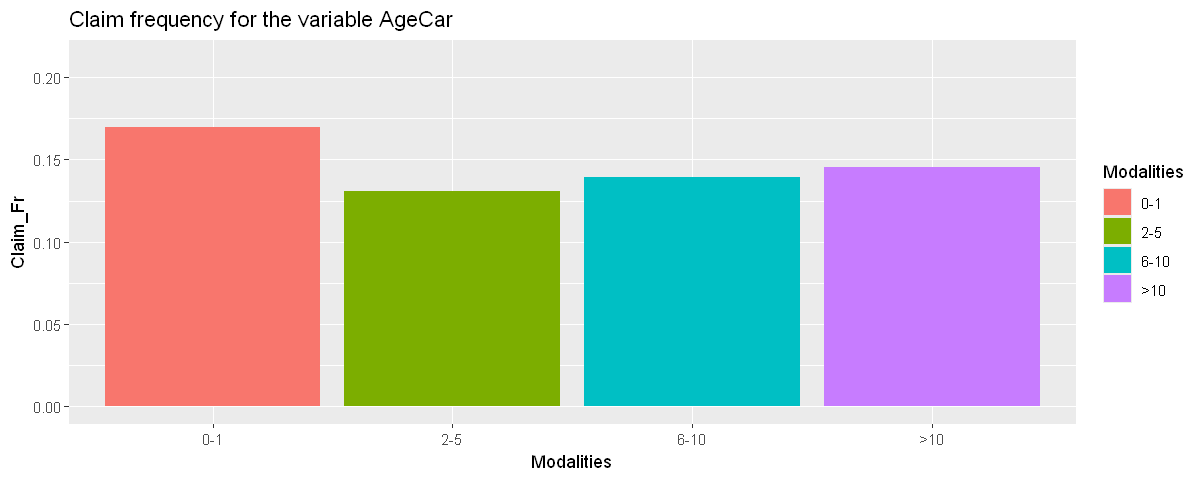

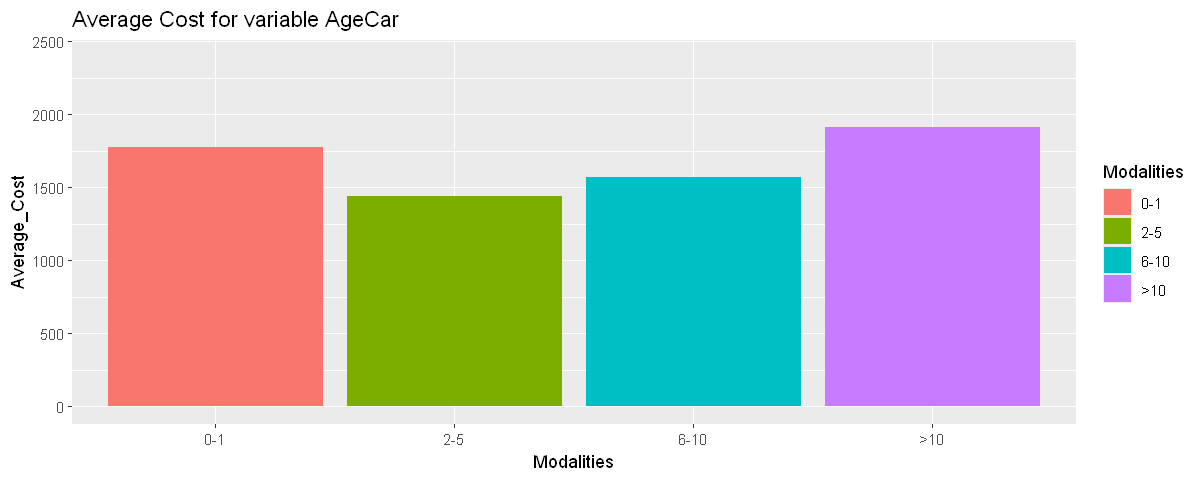

In [10]:
# We use the function fct_relevel to define in which order the modalities should be processed
Data$AgeCar <- fct_relevel(Data[["AgeCar"]], "0-1", "2-5", "6-10", ">10")

graph_results[["AgeCar"]] <- Descriptive_Analysis(Data,"AgeCar")

print(graph_results[["AgeCar"]][[1]])  # For exposure
print(graph_results[["AgeCar"]][[2]])  # For claim frequency
print(graph_results[["AgeCar"]][[3]])  # For average claim amount

### 1.3 Data Preparation

Reference classes can be determined using the results of the above descriptive analysis.

In this part we will rename the modalities so that the reference classes appears first. This can be done using the function fct_relevel.

But before doing that, let's clarify what we mean by 'reference class'. This is particularly useful when dealing with GLM. Indeed, the goal of the GLM is to determine a 
β for each feature (and for each modality within these features). Or, if we take the case of a feature having n modalities, we only need to have 
n−1 βs for this feature.

Indeed we are comparing the effect of a particular modality to a 'level zero' which is obtained through the intercept. But this 'level zero' or 'reference level' is computed on another modality, the 'reference modality'.

How is this reference modality obtained ? There is no particular rule, but it is usually the most frequent modality / the most relevant one within the data (for example if you work with 5 levels from unhappy to really happy, you could use the neutral modality as point of comparison).

The results will be however the same whatever modality is chosen as reference. The coefficients 
βs will just have a shift to balance the effect of the other reference category. So you are free to choose the reference level as you want, but you have to be aware of this choice in the further analysis.

In our case we will choose the most frequent modality as the reference one.

In [11]:
print(levels(Data[["AgeCar"]]))

# The fct_relevel function takes as argument the vector of values and one of its modality
# It then declare the stated modality as the referenced one
# It does not have an impact yet, but you will see its effect when starting to model
Data[["Sex"]] <- fct_relevel(Data[["Sex"]], "Male")
Data[["Use"]] <- fct_relevel(Data[["Use"]], "Private")
Data[["Fleet"]] <- fct_relevel(Data[["Fleet"]], "No")
Data[["Sport"]] <- fct_relevel(Data[["Sport"]], "No")
Data[["Cover"]] <- fct_relevel(Data[["Cover"]], "MTPL")
Data[["Fuel"]] <- fct_relevel(Data[["Fuel"]], "Petrol")
Data[["AgeCar"]] <- fct_relevel(Data[["AgeCar"]], "6-10")
Data[["Power"]] <- fct_relevel(Data[["Power"]], "<66")
Data[["Split"]] <- fct_relevel(Data[["Split"]], "Once")

print(levels(Data[["AgeCar"]]))

[1] "0-1"  "2-5"  "6-10" ">10" 
[1] "6-10" "0-1"  "2-5"  ">10" 


### 1.4 Error Functions

In this short part we will define two error functions which will be uses during this training. Some basic error functions like MSE, MAE or RMSE are already coded in R and belong to the Metrics package.

However these functions do not fit well to determine the error of counting distribution or do not always reflect the phenomenon we want to underline.

So, we will implement the gamma and poisson deviance in order to assess the quality of the models.

In [12]:
# Function returning the deviance of the Poisson
deviance_p <- function (truevalues, predictions){
  sum <- 0
  for (k in 1:length(predictions)) {
    if (truevalues[k] == 0)  { 
      sum <- sum + predictions[k]
    }else{
      sum <- sum + truevalues[k] * log (truevalues[k]/predictions[k]) - 
        (truevalues[k] - predictions[k])
    }
  }
  return(2 * as.numeric(sum))
}

In [13]:
# Function returning the deviance of the Gamma
deviance_g <- function(truevalues, predictions,weights){
  sum <- 0
  for (k in 1:length(predictions)){
    sum <- sum + weights[k]*( log(truevalues[k]/predictions[k]) - 
                                ((truevalues[k]-predictions[k])/predictions[k]))
    
  }
  return(-2* as.numeric(sum))
}

### 1.5 Split trainiing/test sets

We will split our data into a training set and a test set. In order to have a fair and balanced repartition of the data, we will use the createDataPartition function from the caret package.

This function returns a row of integers which are the row indexes of the training date (if we put p = 0.8 then we will have a vector of size 
0.8×len(Data)).

However, we want to have a balanced repartition. It means that if we assume that 10 policyholders in the database have all the same characteristics, 8 will be in the training set and 2 in the test set (if we choose to split 80/20). In other terms it means that if we have 10 policyholders with AgeCar = 0-1, Sex = Male, Fuel = Petrol, Split = Once, Fleet = No, Sport = No, Cover = MTPL++, Power < 66, 8 of these profiles will go to the training set, and the rest will be kept in the test set.

If we don't pay attention to it and just use CreateDataPartition on one column, for example 'Sex', we will have a split where 80% of the male will be in the training set, and 20% will be in the test set. But it is not because it is true for the feature sex that the split will be equivalent when it comes to other features.

That is why we need to create a new factor variable, which is a concatenation of all the features of each policyholder. This way, we make sure that our split is fair regarding all categorical features.

However, we might not have enough date for each unique profile (less than 5 observations for example), which leads all observations to be put in the training set and none in the testing set. This is done in order to respect the 80/20 repartition set. This raises warnings in R; to not display them we temporarily disable them through the options command line.

In [14]:
set.seed(223)

defaultW <- getOption("warn") 
options(warn = -1) 

# We create a new factor variable regrouping all modalities'combinations possible
factorvariable <- c("AgeCar","Sex",'Fuel','Split',"Use","Fleet","Sport","Cover","Power")
tmp <- NULL
for (var in factorvariable)
{
  tmp <- paste(tmp,Data[[var]])
}

# We partition the data, such as 80% of each new categories go to the training set
# and 20% on the test set

inTraining <- createDataPartition(tmp, p = 0.8, list = FALSE)

options(warn = defaultW)

Data_train <- Data[inTraining,]
Data_test <- Data[-inTraining,]

head(Data_train)

,Age,RiskExp,NbrClaims,ClaimAmount,AgeCar,Sex,Fuel,Split,Use,Fleet,Sport,Cover,Power
,<int>,<dbl>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,64,1.00000000,0,0.0000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110
2,28,0.04657534,1,155.9746,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110
3,58,0.40273973,0,0.0000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66
5,29,1.00000000,0,0.0000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66
6,25,0.29589041,0,0.0000,>10,Female,Petrol,Twice,Private,Yes,No,MTPL+,66-110
7,34,1.00000000,0,0.0000,>10,Female,Petrol,Monthly,Private,No,No,MTPL,<66


In [15]:
length(Data_test$Age) / (length(Data_train$Age) + length(Data_test$Age))

[1] 0.1965758

### 1.6 Split between attritional and atypical sets

Let's compute the mean cost on the database and remove the atypical claims, which will be treated in a next part of this training.

First let's look at how our data are distributed:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


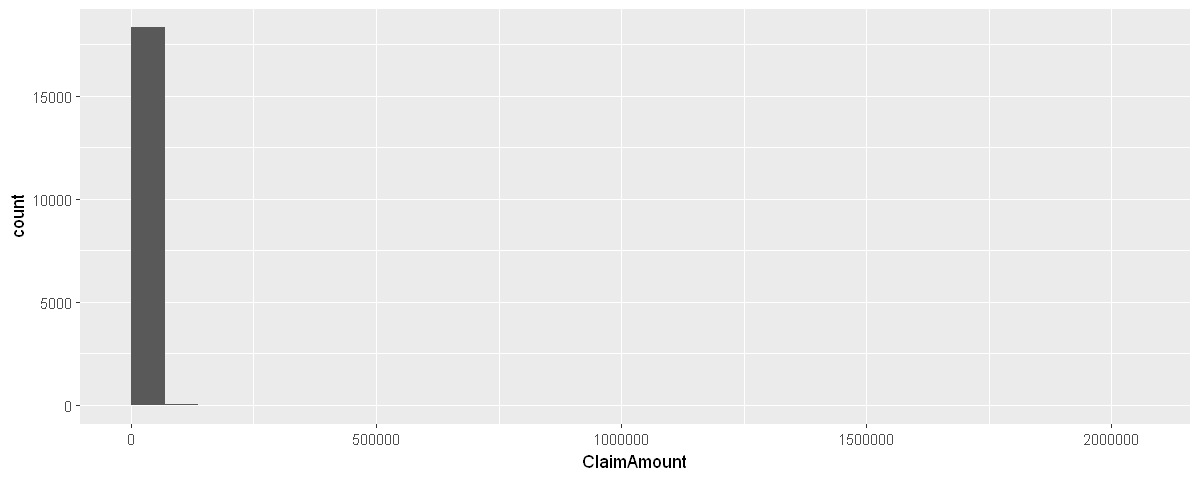

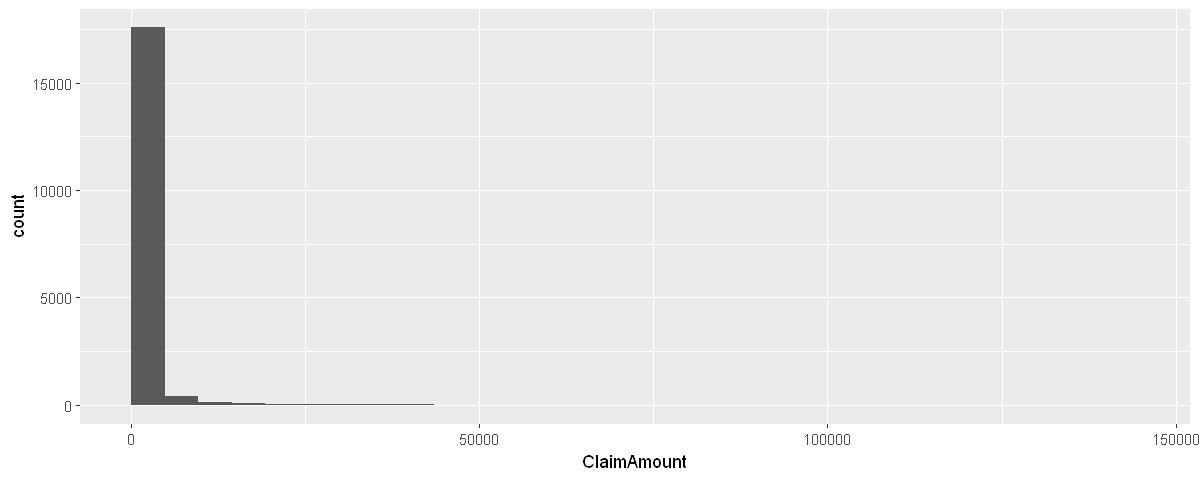

In [16]:
print(ggplot(data = subset(Data, ClaimAmount > 0), aes(x = ClaimAmount)) + geom_histogram(boundary = 0))

print(ggplot(data = subset(Data, ClaimAmount > 0 & ClaimAmount < 150000), aes(x = ClaimAmount)) 
      + geom_histogram(boundary = 0))

In [17]:
#Considering the distribution of the amount of claims within our portfolio, we decide to set up the threshold at 100 000€.

# Compute mean cost
MeanCharge <- with(Data_train,ifelse(NbrClaims != 0, ClaimAmount/NbrClaims,0))
Data_train[["MeanCharge"]]<-MeanCharge

MeanCharge <- with(Data_test,ifelse(NbrClaims != 0, ClaimAmount/NbrClaims,0))
Data_test[["MeanCharge"]]<-MeanCharge


# Atypical losses are treated in another analysis
L <- Data_train[["MeanCharge"]] < 100000
DataAttr_train <- Data_train[L,]

L <- Data_test[["MeanCharge"]] < 100000
DataAttr_test <- Data_test[L,]

## 2-GLM Analysis:frequency

Here is a non-exhaustive list of packages that can be used to implement GLM:

* fastglm : package to fit GLM efficiently using ‘RcppEigen’ (improved speed)

* glmnet : LASSO and Elastic-net regularized GLM

* Bigglm : Creates a GLM object that uses only p^2 memory for p variables (Large database)

* bestglm : Allows the use of CV, and provides new information criteria such BICq, AIC, BIC and EBIC for selecting the best model

* glm.deploy : Write a glm model into C or Java

Now, we will model the claim's frequency using GLMs.

In [18]:
DataFreq_train <- DataAttr_train
DataFreq_test <- DataAttr_test

Now we can perform a first GLM Analysis using the glm function. The Anova function displays all the explanatory variable and their corresponding 
p-value whereas the summary function displays all the modalities, their estimate and the corresponding p-values.
Before moving on, let's develop what is the p-value and why it is of great help in our case.
In a GLM, we obtain for each modality of each categorical feature a parameter estimate β, exception made for the reference classes which were defined earlier. But R is going to provide us some more information on these estimates: a standard error term, a 
z-score and a p-value which will be presented under the column 
Pr(>|z|).
But what is the z-score ? This is the test-statistic for the Wald-test which states that the value of the parameter is 0. It is equal to the value of the parameter divided by the standard error.
In other terms, it is the test-statistic which compares 
H0 to H1 :
H0:βj=0.
H1:βj<>0.
If the null-hypothesis is true (i.e. the parameter is 0 in the population) and we were to draw many samples from our population and compute the 
z-statistic in each of them, then those z-statistics would follow a standard normal distribution. This is the Wald-test.

The p-value is drawn from this statistic. The highest the z-value, the less likely that the true regression coefficient is 0. A good rule of thumb is to use a cut-off value of 2 which approximately corresponds to a two-sided hypothesis test with a significance level of 
α=0.05 (our p-value).

An Anova analysis is also performed. It is quite similar to the one we just introduced, except that this time we test the relevance of the feature on its globality, and not just for each of its modalities.

In [19]:
GLM_Analysis<-glm(NbrClaims ~ offset(log(RiskExp))+Sex+Use+Fleet+Sport+Cover+Fuel+AgeCar
                  +Power+Split,family=poisson(link=log), data=DataFreq_train)

Anova(GLM_Analysis, test.statistic="Wald",type=3,singular.ok=TRUE) ;

summary(GLM_Analysis)

Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),1,13754.844880,0.000000e+00
Sex,1,28.506097,9.340388e-08
Use,1,0.210069,6.467133e-01
Fleet,1,10.697531,1.072786e-03
Sport,1,3.652900,5.597166e-02
Cover,2,74.342939,7.188460e-17
Fuel,1,143.315352,5.015118e-33
AgeCar,3,57.500490,2.009408e-12
Power,2,24.781706,4.156434e-06



Call:
glm(formula = NbrClaims ~ offset(log(RiskExp)) + Sex + Use + 
    Fleet + Sport + Cover + Fuel + AgeCar + Power + Split, family = poisson(link = log), 
    data = DataFreq_train)

Coefficients:
                 Estimate Std. Error  z value Pr(>|z|)    
(Intercept)     -2.178330   0.018574 -117.281  < 2e-16 ***
SexFemale        0.094898   0.017774    5.339 9.34e-08 ***
UseProfessional  0.016557   0.036124    0.458 0.646713    
FleetYes        -0.156492   0.047846   -3.271 0.001073 ** 
SportYes         0.148824   0.077867    1.911 0.055972 .  
CoverMTPL+      -0.156152   0.019157   -8.151 3.61e-16 ***
CoverMTPL+++    -0.141172   0.027149   -5.200 1.99e-07 ***
FuelGasoil       0.203043   0.016961   11.971  < 2e-16 ***
AgeCar0-1        0.195294   0.037034    5.273 1.34e-07 ***
AgeCar2-5       -0.071074   0.020165   -3.525 0.000424 ***
AgeCar>10        0.002353   0.020801    0.113 0.909950    
Power>110        0.191970   0.077721    2.470 0.013511 *  
Power66-110      0.086097   0.01

In the summary above you can retrieve the different statistics mentioned above. The Anova function enables you to perform a Wald test on the global feature, and not at a modality level. It is useful when some modalities are not really significant and you wonder if you should keep or not the feature as is.
Here we have some feature with a p-value higher than our threshold (5%). The usual way to proceed is to remove features with high-value one by one, starting with the one with the highest p-value. It prevents you from removing a feature which has only high p-value because of collinearity with other not relevant features.
That is what we are going to do now. We are going to run multiple GLMs and remove one feature at a time.
We start with the variable 'Use', which has the highest p-value (64%) and thus can be removed from the study.

In [20]:
GLM_Analysis<-glm(NbrClaims ~ offset(log(RiskExp))+Sex+Fleet+Sport+Cover+Fuel+AgeCar
                  +Power+Split,family=poisson(link=log), data=DataFreq_train)

Anova(GLM_Analysis, test.statistic="Wald",type=3,singular.ok=TRUE) ;

summary(GLM_Analysis)

Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),1,13778.395613,0.000000e+00
Sex,1,28.458905,9.570855e-08
Fleet,1,10.513406,1.185116e-03
Sport,1,3.631565,5.669347e-02
Cover,2,74.148844,7.921055e-17
Fuel,1,144.789954,2.387165e-33
AgeCar,3,57.399034,2.112167e-12
Power,2,25.507026,2.892142e-06
Split,3,568.360424,7.279744e-123



Call:
glm(formula = NbrClaims ~ offset(log(RiskExp)) + Sex + Fleet + 
    Sport + Cover + Fuel + AgeCar + Power + Split, family = poisson(link = log), 
    data = DataFreq_train)

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  -2.177947   0.018554 -117.381  < 2e-16 ***
SexFemale     0.094814   0.017773    5.335 9.57e-08 ***
FleetYes     -0.154470   0.047640   -3.242 0.001185 ** 
SportYes      0.148379   0.077862    1.906 0.056693 .  
CoverMTPL+   -0.156014   0.019155   -8.145 3.80e-16 ***
CoverMTPL+++ -0.140278   0.027078   -5.181 2.21e-07 ***
FuelGasoil    0.203583   0.016919   12.033  < 2e-16 ***
AgeCar0-1     0.195020   0.037030    5.266 1.39e-07 ***
AgeCar2-5    -0.071050   0.020165   -3.523 0.000426 ***
AgeCar>10     0.002337   0.020801    0.112 0.910530    
Power>110     0.194204   0.077566    2.504 0.012290 *  
Power66-110   0.086847   0.018676    4.650 3.32e-06 ***
SplitMonthly  0.407587   0.023674   17.216  < 2e-16 ***
SplitThrice   0.52487

In [22]:
#Now we see that 'Sport' has the highest :p-value (6%) and exceeds our threshold, so we remove it as well.
GLM_Analysis<-glm(NbrClaims ~ offset(log(RiskExp))+Sex+Fleet+Cover+Fuel+AgeCar
                  +Power+Split,family=poisson(link=log), data=DataFreq_train)

Anova(GLM_Analysis, test.statistic="Wald",type=3,singular.ok=TRUE) ;

summary(GLM_Analysis)

Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),1,13779.46742,0.000000e+00
Sex,1,28.43931,9.668200e-08
Fleet,1,10.52693,1.176476e-03
Cover,2,74.54690,6.491525e-17
Fuel,1,143.45115,4.683707e-33
AgeCar,3,57.39592,2.115407e-12
Power,2,32.10061,1.070141e-07
Split,3,569.30370,4.546175e-123



Call:
glm(formula = NbrClaims ~ offset(log(RiskExp)) + Sex + Fleet + 
    Cover + Fuel + AgeCar + Power + Split, family = poisson(link = log), 
    data = DataFreq_train)

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  -2.177139   0.018547 -117.386  < 2e-16 ***
SexFemale     0.094782   0.017773    5.333 9.67e-08 ***
FleetYes     -0.154570   0.047640   -3.245 0.001176 ** 
CoverMTPL+   -0.156304   0.019155   -8.160 3.35e-16 ***
CoverMTPL+++ -0.141065   0.027076   -5.210 1.89e-07 ***
FuelGasoil    0.202478   0.016905   11.977  < 2e-16 ***
AgeCar0-1     0.193514   0.037021    5.227 1.72e-07 ***
AgeCar2-5    -0.072048   0.020159   -3.574 0.000351 ***
AgeCar>10     0.002013   0.020801    0.097 0.922903    
Power>110     0.237845   0.073734    3.226 0.001257 ** 
Power66-110   0.091009   0.018531    4.911 9.05e-07 ***
SplitMonthly  0.406441   0.023666   17.174  < 2e-16 ***
SplitThrice   0.526416   0.026486   19.875  < 2e-16 ***
SplitTwice    0.216217   0.01

With the Type 3 analysis (first analysis displayed), we observe that all the variables are significant; this is because the 
p-value presented under the column Pr(>Chisq)is way under our threshold for all features. So, with a confidence level of 95% we can say that all these variable appear as relevant (aka their β coefficient is not 0 => they have an impact on the final prediction).

However, all the modalities are not significant and we will have a first look at the confidence interval around the predictions. Indeed, for a model to be performant, it should only have relevant and significant modalities. Thus, some modalities can be grouped with other ones if their impact is similar.

In [23]:
# We use the confint.default function of the GLM to compute confindence intervals around the prediction
# It means that the true value for the parameter should lie (with a 95% confidence level) within this interval
# The higher the confidence level, the larger the interval 
confint.default(GLM_Analysis,level = 0.95)   

# It is particularly useful to note interval which include the value 0 as it means that the model do not know if the impact
# of this particular modality/feature is positive or negative -> in other words, this feature is not good in helping

,2.5 %,97.5 %
(Intercept),-2.21348982,-2.14078755
SexFemale,0.05994730,0.12961729
FleetYes,-0.24794387,-0.06119691
CoverMTPL+,-0.19384648,-0.11876078
CoverMTPL+++,-0.19413254,-0.08799816
FuelGasoil,0.16934402,0.23561204
AgeCar0-1,0.12095383,0.26607366
AgeCar2-5,-0.11155797,-0.03253802
AgeCar>10,-0.03875545,0.04278150
Power>110,0.09332940,0.38235979


The following remarks can be done:

* Variable Cover: we can try to gather MTPL+ and MTPL+++ as the predicted value of the first one is in the confidence interval of the other one
* Variable Split: there is no overlapping of the confidence intervals
* Variable Power: 66-110 and >110 are overlapping
* Variable AgeCar: some modalities are not significative --> we can try to gather them

We can also use the fit.contrast function as to test the signigicance of individual modalities for potential further groupings. fit.contrast(GLM_Analysis,"AgeCar",c(-1,1,0,0)) test if the modalities "6-10" and ">10" should be gathered.

In [25]:
fit.contrast(GLM_Analysis,"Cover",c(-1,1,0)) ;
fit.contrast(GLM_Analysis,"Cover",c(-1,0,1)) ;
fit.contrast(GLM_Analysis,"Cover",c(0,-1,1)) ;
 
fit.contrast(GLM_Analysis,"Power",c(-1,1,0)) ;
fit.contrast(GLM_Analysis,"Power",c(-1,0,1)) ;
fit.contrast(GLM_Analysis,"Power",c(0,-1,1)) ;

fit.contrast(GLM_Analysis,"AgeCar",c(-1,1,0,0)) ;
fit.contrast(GLM_Analysis,"AgeCar",c(-1,0,1,0)) ;
fit.contrast(GLM_Analysis,"AgeCar",c(-1,0,0,1)) ;
fit.contrast(GLM_Analysis,"AgeCar",c(0,-1,1,0)) ;
fit.contrast(GLM_Analysis,"AgeCar",c(0,-1,0,1)) ;
fit.contrast(GLM_Analysis,"AgeCar",c(0,0,-1,1)) ;

fit.contrast(GLM_Analysis,"Split",c(-1,1,0,0)) 
fit.contrast(GLM_Analysis,"Split",c(-1,0,1,0))
fit.contrast(GLM_Analysis,"Split",c(-1,0,0,1))
fit.contrast(GLM_Analysis,"Split",c(0,-1,1,0))
fit.contrast(GLM_Analysis,"Split",c(0,-1,0,1))
fit.contrast(GLM_Analysis,"Split",c(0,0,-1,1))

                     Estimate Std. Error   z value     Pr(>|z|)
Cover c=( -1 1 0 ) -0.1563036 0.01915487 -8.159995 3.350376e-16

                     Estimate Std. Error   z value     Pr(>|z|)
Cover c=( -1 0 1 ) -0.1410654 0.02707559 -5.210055 1.887842e-07

                     Estimate Std. Error   z value  Pr(>|z|)
Cover c=( 0 -1 1 ) 0.01523828 0.02790613 0.5460549 0.5850282

                    Estimate Std. Error  z value    Pr(>|z|)
Power c=( -1 1 0 ) 0.2378446  0.0737336 3.225729 0.001256523

                     Estimate Std. Error  z value     Pr(>|z|)
Power c=( -1 0 1 ) 0.09100927 0.01853099 4.911193 9.052377e-07

                     Estimate Std. Error   z value   Pr(>|z|)
Power c=( 0 -1 1 ) -0.1468353 0.07450891 -1.970708 0.04875727

                       Estimate Std. Error  z value     Pr(>|z|)
AgeCar c=( -1 1 0 0 ) 0.1935137 0.03702105 5.227128 1.721633e-07

                       Estimate Std. Error   z value     Pr(>|z|)
AgeCar c=( -1 0 1 0 ) -0.072048 0.02015852 -3.574072 0.0003514728

                         Estimate Std. Error    z value  Pr(>|z|)
AgeCar c=( -1 0 0 1 ) 0.002013023 0.02080062 0.09677707 0.9229034

                        Estimate Std. Error   z value     Pr(>|z|)
AgeCar c=( 0 -1 1 0 ) -0.2655617 0.03633246 -7.309214 2.687104e-13

                        Estimate Std. Error   z value     Pr(>|z|)
AgeCar c=( 0 -1 0 1 ) -0.1915007 0.03941289 -4.858834 1.180788e-06

                        Estimate Std. Error  z value    Pr(>|z|)
AgeCar c=( 0 0 -1 1 ) 0.07406102 0.02418722 3.061989 0.002198713

                      Estimate Std. Error  z value    Pr(>|z|)
Split c=( -1 1 0 0 ) 0.4064407 0.02366556 17.17435 4.13256e-66

                      Estimate Std. Error  z value     Pr(>|z|)
Split c=( -1 0 1 0 ) 0.5264156 0.02648643 19.87492 6.709446e-88

                      Estimate Std. Error  z value     Pr(>|z|)
Split c=( -1 0 0 1 ) 0.2162175 0.01864682 11.59541 4.347946e-31

                      Estimate Std. Error  z value     Pr(>|z|)
Split c=( 0 -1 1 0 ) 0.1199749 0.03118842 3.846776 0.0001196824

                       Estimate Std. Error   z value     Pr(>|z|)
Split c=( 0 -1 0 1 ) -0.1902232 0.02495711 -7.622007 2.497624e-14

                       Estimate Std. Error   z value     Pr(>|z|)
Split c=( 0 0 -1 1 ) -0.3101981 0.02758278 -11.24608 2.421186e-29

In [26]:
levels(DataFreq_train[["AgeCar"]])  ;

DataFreq_train[["AgeCar"]] <- with(DataFreq_train, 
                                       ifelse(AgeCar=="2-5","2-5",
                                              ifelse(AgeCar == "0-1", "0-1", ">5")))
DataFreq_train[["AgeCar"]] <-as.factor(DataFreq_train[["AgeCar"]]) 

# Do not forget to set the reference level as it was set before !
DataFreq_train[["AgeCar"]] <- fct_relevel(DataFreq_train[["AgeCar"]], ">5")

# Now we can run once again a GLM analysis on our 'updated' data

GLM_Analysis<-glm(NbrClaims ~ offset(log(RiskExp))+Sex+Fleet+Cover+Fuel+AgeCar
                  +Power+Split,family=poisson(link=log), data=DataFreq_train)

Anova(GLM_Analysis, test.statistic="Wald",type=3,singular.ok=TRUE) ;

summary(GLM_Analysis)

[1] "6-10" "0-1"  "2-5"  ">10"

Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),1,17359.76038,0.000000e+00
Sex,1,28.44461,9.641763e-08
Fleet,1,10.53322,1.172476e-03
Cover,2,77.42605,1.538677e-17
Fuel,1,143.81645,3.896925e-33
AgeCar,2,57.38675,3.456411e-13
Power,2,32.19377,1.021439e-07
Split,3,571.55416,1.478487e-123



Call:
glm(formula = NbrClaims ~ offset(log(RiskExp)) + Sex + Fleet + 
    Cover + Fuel + AgeCar + Power + Split, family = poisson(link = log), 
    data = DataFreq_train)

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  -2.17632    0.01652 -131.756  < 2e-16 ***
SexFemale     0.09479    0.01777    5.333 9.64e-08 ***
FleetYes     -0.15461    0.04764   -3.245 0.001172 ** 
CoverMTPL+   -0.15664    0.01883   -8.318  < 2e-16 ***
CoverMTPL+++ -0.14128    0.02698   -5.236 1.64e-07 ***
FuelGasoil    0.20238    0.01688   11.992  < 2e-16 ***
AgeCar0-1     0.19293    0.03653    5.281 1.28e-07 ***
AgeCar2-5    -0.07264    0.01921   -3.781 0.000156 ***
Power>110     0.23771    0.07372    3.224 0.001262 ** 
Power66-110   0.09087    0.01848    4.918 8.72e-07 ***
SplitMonthly  0.40649    0.02366   17.181  < 2e-16 ***
SplitThrice   0.52658    0.02643   19.920  < 2e-16 ***
SplitTwice    0.21628    0.01864   11.606  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01

In [27]:
#We then redo the same process and further try to perform some groupings:
# Other gatherings? -> Same step as above : if you want to see the output, just remove the "#" at the beginning of each line
#fit.contrast(GLM_Analysis,"Cover",c(-1,1,0));
#fit.contrast(GLM_Analysis,"Cover",c(-1,0,1));
#fit.contrast(GLM_Analysis,"Cover",c(0,-1,1));

#fit.contrast(GLM_Analysis,"Power",c(-1,1,0));
#fit.contrast(GLM_Analysis,"Power",c(-1,0,1));
#fit.contrast(GLM_Analysis,"Power",c(0,-1,1));

#fit.contrast(GLM_Analysis,"AgeCar",c(-1,1,0));
#fit.contrast(GLM_Analysis,"AgeCar",c(-1,0,1));
#fit.contrast(GLM_Analysis,"AgeCar",c(0,-1,1));

#fit.contrast(GLM_Analysis,"Split",c(-1,1,0,0)) 
#fit.contrast(GLM_Analysis,"Split",c(-1,0,1,0))
#fit.contrast(GLM_Analysis,"Split",c(-1,0,0,1))
#fit.contrast(GLM_Analysis,"Split",c(0,-1,1,0))
#fit.contrast(GLM_Analysis,"Split",c(0,-1,0,1))
#fit.contrast(GLM_Analysis,"Split",c(0,0,-1,1))


The modalities "MTPL+" and "MTPL+++" of "Cover" should be gathered as ("More") as the p-value equals 58%

In [28]:
levels(DataFreq_train[["Cover"]]) ;

DataFreq_train[["Cover"]] <- with(DataFreq_train, 
                                      ifelse(Cover=="MTPL","MTPL","More"))  
DataFreq_train[["Cover"]] <-as.factor(DataFreq_train[["Cover"]]) 

# Do not forget to set the reference level as it was set before !
DataFreq_train[["Cover"]] <- fct_relevel(DataFreq_train[["Cover"]], "MTPL")

GLM_Analysis<-glm(NbrClaims ~ offset(log(RiskExp))+Sex+Fleet+Cover+Fuel+AgeCar
                  +Power+Split,family=poisson(link=log), data=DataFreq_train)
                      
Anova(GLM_Analysis, test.statistic="Wald",type=3,singular.ok=TRUE);

summary(GLM_Analysis)

[1] "MTPL"    "MTPL+"   "MTPL+++"

Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),1,17593.77389,0.000000e+00
Sex,1,28.58280,8.977619e-08
Fleet,1,10.39530,1.263367e-03
Cover,1,77.22576,1.524916e-18
Fuel,1,144.69247,2.507238e-33
AgeCar,2,58.09543,2.425140e-13
Power,2,32.86314,7.309043e-08
Split,3,574.34632,3.669116e-124



Call:
glm(formula = NbrClaims ~ offset(log(RiskExp)) + Sex + Fleet + 
    Cover + Fuel + AgeCar + Power + Split, family = poisson(link = log), 
    data = DataFreq_train)

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  -2.17735    0.01642 -132.642  < 2e-16 ***
SexFemale     0.09500    0.01777    5.346 8.98e-08 ***
FleetYes     -0.15344    0.04759   -3.224 0.001263 ** 
CoverMore    -0.15267    0.01737   -8.788  < 2e-16 ***
FuelGasoil    0.20279    0.01686   12.029  < 2e-16 ***
AgeCar0-1     0.19783    0.03542    5.585 2.33e-08 ***
AgeCar2-5    -0.07030    0.01872   -3.755 0.000174 ***
Power>110     0.23896    0.07368    3.243 0.001183 ** 
Power66-110   0.09162    0.01842    4.972 6.61e-07 ***
SplitMonthly  0.40771    0.02355   17.309  < 2e-16 ***
SplitThrice   0.52667    0.02643   19.924  < 2e-16 ***
SplitTwice    0.21599    0.01863   11.595  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for pois

In [30]:
#We repeat once again the same steps to be sure we have the best model possible:
fit.contrast(GLM_Analysis,"Power",c(-1,1,0));
fit.contrast(GLM_Analysis,"Power",c(-1,0,1));
fit.contrast(GLM_Analysis,"Power",c(0,-1,1));

fit.contrast(GLM_Analysis,"AgeCar",c(-1,1,0));
fit.contrast(GLM_Analysis,"AgeCar",c(-1,0,1));
fit.contrast(GLM_Analysis,"AgeCar",c(0,-1,1));

#fit.contrast(GLM_Analysis,"Split",c(-1,1,0,0)) 
#fit.contrast(GLM_Analysis,"Split",c(-1,0,1,0))
#fit.contrast(GLM_Analysis,"Split",c(-1,0,0,1))
#fit.contrast(GLM_Analysis,"Split",c(0,-1,1,0))
#fit.contrast(GLM_Analysis,"Split",c(0,-1,0,1))
#fit.contrast(GLM_Analysis,"Split",c(0,0,-1,1))

                    Estimate Std. Error  z value    Pr(>|z|)
Power c=( -1 1 0 ) 0.2389612 0.07368459 3.243028 0.001182667

                     Estimate Std. Error  z value     Pr(>|z|)
Power c=( -1 0 1 ) 0.09161539  0.0184246 4.972451 6.611181e-07

                     Estimate Std. Error   z value   Pr(>|z|)
Power c=( 0 -1 1 ) -0.1473458 0.07450306 -1.977715 0.04796092

                     Estimate Std. Error  z value     Pr(>|z|)
AgeCar c=( -1 1 0 ) 0.1978323 0.03541948 5.585411 2.331486e-08

                       Estimate Std. Error   z value     Pr(>|z|)
AgeCar c=( -1 0 1 ) -0.07029617 0.01872294 -3.754548 0.0001736548

                      Estimate Std. Error   z value     Pr(>|z|)
AgeCar c=( 0 -1 1 ) -0.2681285   0.036034 -7.440986 9.993625e-14

No more gatherings need to be done. All the variables and modalities are significant.
We are thus going to apply our changes to our test dataset.

In [31]:
DataFreq_test[["AgeCar"]] <- with(DataFreq_test, 
                                      ifelse(AgeCar=="2-5","2-5",
                                             ifelse(AgeCar == "0-1", "0-1", ">5")))
DataFreq_test[["Cover"]] <- with(DataFreq_test, ifelse(Cover=="MTPL","MTPL","More"))  

DataFreq_test[["Cover"]] <-as.factor(DataFreq_test[["Cover"]])   
DataFreq_test[["AgeCar"]] <-as.factor(DataFreq_test[["AgeCar"]])   

print(summary(DataFreq_test[["Cover"]]))
print(summary(DataFreq_test[["AgeCar"]]))

 More  MTPL 
13293 18876 
   >5   0-1   2-5 
20572  1448 10149 


In [32]:
#Now we will compute the error on the test dataset and compare it to the error obtained using the simple average as predictor
# Function returning the deviance of the Poisson
predict_test <- predict(GLM_Analysis, newdata = DataFreq_test, type="response")  
Dev_GLM <- deviance_p(DataFreq_test$NbrClaims, predict_test)
Dev_GLM

Lambda <- sum(DataFreq_train$NbrClaims) / sum(DataFreq_train$RiskExp)
Dev_MEAN <- deviance_p(DataFreq_test$NbrClaims, Lambda*DataFreq_test$RiskExp)
Dev_MEAN


[1] 17380.43

[1] 17590.43

The goal here was to test the relevance of our model (let's say, following the hypothesis 
H1, with all the parameters βshaving their value given by the last GLM_Analysis) to the model stated as hypothesis H0 were all the parameters βsare set to 0.
To do that, we will use a χ2test to determine whether or not we can reject the null hypothesis H0(where we use 0 parameters -> the mean of the observations).
As we did earlier, we use a threshold value of 5% to make our decision.

In [33]:
# Null hypothesis: the model with 0 parameter (ie, using the mean)
# H0 is rejected if Delta (= Dev_MEAN - Dev_GLM) is too large (>3.841 for a X² with 1 degree of freedom, 
#                                                              >19.675 for a X² with 11 degrees of freedom)

Delta <- Dev_MEAN - Dev_GLM
pchisq(Delta, df=11, lower.tail=FALSE)

[1] 6.230618e-39

P[Delta>Chisq]=6.230618e−39<5%thus we can reject the null hypothesis .

## 3- GLM Analysis costs

In this part we will perform a Gamma regression on costs.
We will use the same data as for the frequency analysis. We start by eliminating the lines where the claim amount is equal to zero.

In [34]:
DataCosts_train <- DataAttr_train
DataCosts_test <- DataAttr_test


# Eliminate data with cost charge equals to zero
L = DataCosts_train[["MeanCharge"]] != 0 
DataCosts_train = DataCosts_train[L,]

L = DataCosts_test[["MeanCharge"]] != 0 
DataCosts_test = DataCosts_test[L,]

We move on to a first GLM analysis, using a Gamma distribution and the logarithmic link function.

In [36]:
GLM_AnalysisCosts<-glm(MeanCharge ~ Sex+Use+Fleet+Sport+ Cover+Split+Fuel+AgeCar+Power,
                       family=Gamma(link=log),weights=NbrClaims, data = DataCosts_train)

Anova(GLM_AnalysisCosts, type='III', test.statistic='F')

,Sum Sq,Df,F values,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Sex,1.425944e+00,1,0.174553046,6.761028e-01
Use,9.577637e-01,1,0.117242014,7.320501e-01
Fleet,2.818052e+00,1,0.344964063,5.569868e-01
Sport,1.670135e+01,1,2.044450449,1.527833e-01
Cover,2.282555e+02,2,13.970638718,8.677120e-07
Split,1.861637e+01,3,0.759623898,5.165997e-01
Fuel,1.549691e+00,1,0.189701118,6.631719e-01
AgeCar,7.753418e+01,3,3.163711350,2.345509e-02
Power,8.223869e-02,2,0.005033512,9.949791e-01


As we did for the frequency analysis, we are going to proceed step by step. So we are removing features which have a 
p-value (see explanations in the frequency analysis part) higher than our 5% threshold, one by one, starting with the one having the highest p-value. We only stop when the remaining features are significant at our 5% level of confidence.
The p-value of the variable "Power" is the highest and equals 99% so we remove it:

In [37]:
GLM_AnalysisCosts<-glm(MeanCharge ~ Sex+Use+Fleet+Sport+ Cover+Split+Fuel+AgeCar,
                       family=Gamma(link=log),weights=NbrClaims, data = DataCosts_train)

Anova(GLM_AnalysisCosts, type='III', test.statistic='F')

,Sum Sq,Df,F values,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Sex,1.383203e+00,1,0.1693411,6.807040e-01
Use,9.212600e-01,1,0.1127869,7.369981e-01
Fleet,2.875234e+00,1,0.3520057,5.529891e-01
Sport,1.816006e+01,1,2.2232779,1.359656e-01
Cover,2.303610e+02,2,14.1011789,7.617102e-07
Split,1.865590e+01,3,0.7613276,5.156155e-01
Fuel,1.508748e+00,1,0.1847113,6.673616e-01
AgeCar,7.748823e+01,3,3.1622122,2.350320e-02
Residuals,1.203413e+05,14733,NA,NA


The p-value of the variable "Use" is equal to 73% so we remove it:

In [38]:
GLM_AnalysisCosts<-glm(MeanCharge ~ Sex+Fleet+Sport+ Cover+Split+Fuel+AgeCar,
                       family=Gamma(link=log),weights=NbrClaims, data = DataCosts_train)

Anova(GLM_AnalysisCosts, type='III', test.statistic='F')


,Sum Sq,Df,F values,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Sex,1.455886e+00,1,0.1782434,6.728934e-01
Fleet,2.354915e+00,1,0.2883112,5.913129e-01
Sport,1.815140e+01,1,2.2222669,1.360546e-01
Cover,2.304714e+02,2,14.1082496,7.563529e-07
Split,1.916281e+01,3,0.7820312,5.037684e-01
Fuel,1.336541e+00,1,0.1636320,6.858402e-01
AgeCar,7.697693e+01,3,3.1414163,2.418069e-02
Residuals,1.203468e+05,14734,NA,NA


The p-value of the variable "Fuel" is equal to 68% so we remove it:

In [39]:
GLM_AnalysisCosts<-glm(MeanCharge ~ Sex+Fleet+Sport+ Cover+Split+AgeCar,
                       family=Gamma(link=log),weights=NbrClaims, data = DataCosts_train)

Anova(GLM_AnalysisCosts, type='III', test.statistic='F')

,Sum Sq,Df,F values,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Sex,1.206419e+00,1,0.1474356,7.010037e-01
Fleet,2.414663e+00,1,0.2950941,5.869826e-01
Sport,1.907732e+01,1,2.3314258,1.268072e-01
Cover,2.301673e+02,2,14.0642868,7.902790e-07
Split,1.902024e+01,3,0.7748163,5.078732e-01
AgeCar,7.680512e+01,3,3.1287658,2.460214e-02
Residuals,1.205719e+05,14735,NA,NA


The p-value of the variable "Sex" is equal to 70% so we remove it:

In [40]:
GLM_AnalysisCosts<-glm(MeanCharge ~ Fleet+Sport+ Cover+Split+AgeCar,
                       family=Gamma(link=log),weights=NbrClaims, data = DataCosts_train)

Anova(GLM_AnalysisCosts, type='III', test.statistic='F')

,Sum Sq,Df,F values,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Fleet,2.401744e+00,1,0.2932643,5.881445e-01
Sport,1.868212e+01,1,2.2811754,1.309740e-01
Cover,2.305689e+02,2,14.0767784,7.804864e-07
Split,1.914477e+01,3,0.7792224,5.053634e-01
AgeCar,7.711194e+01,3,3.1385778,2.427463e-02
Residuals,1.206833e+05,14736,NA,NA


The p-value of the variable "Fleet" is equal to 59% so we remove it:

In [41]:
GLM_AnalysisCosts<-glm(MeanCharge ~ Sport+ Cover+Split+AgeCar,
                       family=Gamma(link=log),weights=NbrClaims, data = DataCosts_train)

Anova(GLM_AnalysisCosts, type='III', test.statistic='F')

,Sum Sq,Df,F values,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Sport,18.52262,1,2.2626369,1.325497e-01
Cover,230.89648,2,14.1026219,7.606112e-07
Split,18.82484,3,0.7665186,5.126255e-01
AgeCar,77.63190,3,3.1610508,2.354053e-02
Residuals,120641.44856,14737,NA,NA


The p-value of the variable "Split" is equal to 51% so we remove it:

In [42]:
GLM_AnalysisCosts<-glm(MeanCharge ~ Sport+ Cover+AgeCar,
                       family=Gamma(link=log),weights=NbrClaims, data = DataCosts_train)

Anova(GLM_AnalysisCosts, type='III', test.statistic='F')

,Sum Sq,Df,F values,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Sport,16.55557,1,2.006134,1.566852e-01
Cover,238.10702,2,14.426399,5.505776e-07
AgeCar,74.94768,3,3.027281,2.825424e-02
Residuals,121641.49411,14740,NA,NA


The p-value of the variable "Sport" is equal to 15% so we remove it:

In [43]:
GLM_AnalysisCosts<-glm(MeanCharge ~  Cover+AgeCar,
                       family=Gamma(link=log),weights=NbrClaims, data = DataCosts_train)

Anova(GLM_AnalysisCosts, type='III', test.statistic='F')

,Sum Sq,Df,F values,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Cover,232.19269,2,13.899364,9.316814e-07
AgeCar,74.78375,3,2.984437,2.995093e-02
Residuals,123126.22206,14741,NA,NA


Both the "Agecar" and "Cover" variables are significative. We will now try some gatherings:

In [44]:
# "AgeCar" variable
fit.contrast(GLM_AnalysisCosts,"AgeCar",c(-1,1,0,0))
fit.contrast(GLM_AnalysisCosts,"AgeCar",c(-1,0,1,0))
fit.contrast(GLM_AnalysisCosts,"AgeCar",c(-1,0,0,1))
fit.contrast(GLM_AnalysisCosts,"AgeCar",c(0,-1,1,0))
fit.contrast(GLM_AnalysisCosts,"AgeCar",c(0,-1,0,1))
fit.contrast(GLM_AnalysisCosts,"AgeCar",c(0,0,-1,1))

# "Cover" variable
fit.contrast(GLM_AnalysisCosts,"Cover",c(-1,1,0))
fit.contrast(GLM_AnalysisCosts,"Cover",c(-1,0,1))
fit.contrast(GLM_AnalysisCosts,"Cover",c(0,-1,1))

                       Estimate Std. Error  t value   Pr(>|t|)
AgeCar c=( -1 1 0 0 ) 0.1995756  0.1075011 1.856498 0.06340257

                         Estimate Std. Error   t value  Pr(>|t|)
AgeCar c=( -1 0 1 0 ) -0.09220502 0.05784774 -1.593926 0.1109741

                           Estimate Std. Error       t value  Pr(>|t|)
AgeCar c=( -1 0 0 1 ) -4.558944e-07 0.05975334 -7.629606e-06 0.9999939

                        Estimate Std. Error   t value    Pr(>|t|)
AgeCar c=( 0 -1 1 0 ) -0.2917806  0.1053651 -2.769233 0.005625874

                       Estimate Std. Error  t value   Pr(>|t|)
AgeCar c=( 0 -1 0 1 ) -0.199576  0.1141517 -1.74834 0.08042598

                        Estimate Std. Error  t value  Pr(>|t|)
AgeCar c=( 0 0 -1 1 ) 0.09220456 0.06892683 1.337717 0.1810095

                     Estimate Std. Error   t value     Pr(>|t|)
Cover c=( -1 1 0 ) -0.2225343 0.05546115 -4.012436 6.039212e-05

                    Estimate Std. Error  t value   Pr(>|t|)
Cover c=( -1 0 1 ) 0.1603938 0.07711661 2.079886 0.03755323

                    Estimate Std. Error  t value     Pr(>|t|)
Cover c=( 0 -1 1 ) 0.3829281 0.07950803 4.816219 1.477577e-06

The levels "6-10" and ">10" of the AgeCar variable should be gathered as the coresponding p-value is equal to 99%.

In [45]:
levels(DataCosts_train$AgeCar)

DataCosts_train[["AgeCar"]] <- with(DataCosts_train, ifelse(AgeCar=="2-5","2-5",ifelse(AgeCar == "0-1", "0-1", ">5")))
DataCosts_train[["AgeCar"]] <-as.factor(DataCosts_train[["AgeCar"]])   
DataCosts_train[["AgeCar"]] <- fct_relevel(DataCosts_train[["AgeCar"]], ">5")


# Perform a new GLM analysis
GLM_AnalysisCosts<-glm(MeanCharge ~  Cover+AgeCar,
                       family=Gamma(link=log),weights=NbrClaims, data = DataCosts_train)

Anova(GLM_AnalysisCosts, type='III', test.statistic='F')

[1] "6-10" "0-1"  "2-5"  ">10"

,Sum Sq,Df,F values,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Cover,235.09803,2,14.074236,7.824652e-07
AgeCar,74.78375,2,4.476959,1.138339e-02
Residuals,123126.22446,14742,NA,NA


We can try further gatherings on both variables.

In [46]:
 # "AgeCar" variable
fit.contrast(GLM_AnalysisCosts,"AgeCar",c(-1,1,0))
fit.contrast(GLM_AnalysisCosts,"AgeCar",c(-1,0,1))
fit.contrast(GLM_AnalysisCosts,"AgeCar",c(0,-1,1))

# "Cover" variable
fit.contrast(GLM_AnalysisCosts,"Cover",c(-1,1,0))
fit.contrast(GLM_AnalysisCosts,"Cover",c(-1,0,1))
fit.contrast(GLM_AnalysisCosts,"Cover",c(0,-1,1))

                     Estimate Std. Error  t value   Pr(>|t|)
AgeCar c=( -1 1 0 ) 0.1995758  0.1060567 1.881785 0.05988492

                       Estimate Std. Error   t value  Pr(>|t|)
AgeCar c=( -1 0 1 ) -0.09220493 0.05493345 -1.678484 0.0932738

                      Estimate Std. Error   t value    Pr(>|t|)
AgeCar c=( 0 -1 1 ) -0.2917808    0.10536 -2.769371 0.005623492

                    Estimate Std. Error   t value     Pr(>|t|)
Cover c=( -1 1 0 ) -0.222534 0.05447085 -4.085379 4.423774e-05

                   Estimate Std. Error  t value   Pr(>|t|)
Cover c=( -1 0 1 ) 0.160394 0.07674565 2.089942 0.03664008

                   Estimate Std. Error  t value     Pr(>|t|)
Cover c=( 0 -1 1 ) 0.382928 0.07945258 4.819579 1.452949e-06

The levels "2-5" and ">5" of the AgeCar variable should be gathered as the corresponding p-value is equal to 9%.

In [47]:
levels(DataCosts_train$AgeCar)


DataCosts_train[["AgeCar"]] <- with(DataCosts_train, ifelse(AgeCar=="0-1","0-1",">1"))
DataCosts_train[["AgeCar"]] <-as.factor(DataCosts_train[["AgeCar"]])   
DataCosts_train[["AgeCar"]] <- fct_relevel(DataCosts_train[["AgeCar"]], ">1")

# Perform a new GLM analysis
GLM_AnalysisCosts<-glm(MeanCharge ~  Cover+AgeCar,
                       family=Gamma(link=log),weights=NbrClaims, data = DataCosts_train)

Anova(GLM_AnalysisCosts, type='III', test.statistic='F')

[1] ">5"  "0-1" "2-5"

,Sum Sq,Df,F values,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Cover,230.88313,2,13.725650,1.108073e-06
AgeCar,51.25616,1,6.094201,1.357388e-02
Residuals,123998.12942,14743,NA,NA


The Agecar variable cannot be grouped anymore but we can still try some gatherings on the Cover variable.

In [48]:
fit.contrast(GLM_AnalysisCosts,"Cover",c(-1,1,0))
fit.contrast(GLM_AnalysisCosts,"Cover",c(-1,0,1))
fit.contrast(GLM_AnalysisCosts,"Cover",c(0,-1,1))

                     Estimate Std. Error   t value     Pr(>|t|)
Cover c=( -1 1 0 ) -0.2434211 0.05322812 -4.573167 4.843173e-06

                    Estimate Std. Error  t value  Pr(>|t|)
Cover c=( -1 0 1 ) 0.1123112 0.07100614 1.581712 0.1137369

                    Estimate Std. Error  t value     Pr(>|t|)
Cover c=( 0 -1 1 ) 0.3557323 0.07781207 4.571686 4.877497e-06

The modalities "MTPL" and "MTPL+++" of "Cover" should be gathered ("Other") as the p-value equals 11%

In [49]:
levels(DataCosts_train$Cover)

DataCosts_train[["Cover"]] <- with(DataCosts_train, ifelse(Cover=="MTPL+","MTPL+","Other"))  
DataCosts_train[["Cover"]] <-as.factor(DataCosts_train[["Cover"]])   
DataCosts_train[["Cover"]] <- fct_relevel(DataCosts_train[["Cover"]], "Other")

# Perform a new GLM analysis
GLM_AnalysisCosts<-glm(MeanCharge ~  Cover+AgeCar,
                       family=Gamma(link=log),weights=NbrClaims, data = DataCosts_train)

Anova(GLM_AnalysisCosts, type='III', test.statistic='F')
summary(GLM_AnalysisCosts)

[1] "MTPL"    "MTPL+"   "MTPL+++"

,Sum Sq,Df,F values,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Cover,209.71599,1,24.871683,6.197272e-07
AgeCar,83.46094,1,9.898216,1.657682e-03
Residuals,124320.19584,14744,NA,NA



Call:
glm(formula = MeanCharge ~ Cover + AgeCar, family = Gamma(link = log), 
    data = DataCosts_train, weights = NbrClaims)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.23973    0.02707 267.487  < 2e-16 ***
CoverMTPL+  -0.26385    0.05173  -5.101 3.42e-07 ***
AgeCar0-1    0.29691    0.09856   3.012   0.0026 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Gamma family taken to be 8.431918)

    Null deviance: 34005  on 14746  degrees of freedom
Residual deviance: 33699  on 14744  degrees of freedom
AIC: 264239

Number of Fisher Scoring iterations: 7


No more gatherings can be performed. These changes can be applied on the test set dand we can compute the error obtained on this test dataset and compare it with the one obtained using a simple average.

In [50]:
## Apply these changes on the test dataset
DataCosts_test[["AgeCar"]] <- with(DataCosts_test, ifelse(AgeCar=="0-1","0-1",">1"))
DataCosts_test[["Cover"]] <- with(DataCosts_test, ifelse(Cover=="MTPL+","MTPL+","Other"))  

# Compute the error on the test dataset and compare it to the error obtained using the simple average
predict_test <- predict(GLM_AnalysisCosts, newdata = DataCosts_test, type="response")  
Cost_Dev_GLM <- deviance_g(DataCosts_test$MeanCharge, predict_test,DataCosts_test$NbrClaims)
Cost_Dev_GLM

Mu <- sum(DataCosts_train$ClaimAmount)/sum(DataCosts_train$NbrClaims)
Cost_Dev_MEAN <- deviance_g(DataCosts_test$MeanCharge, 
                            rep(Mu, nrow(DataCosts_test)),DataCosts_test$NbrClaims)
Cost_Dev_MEAN

[1] 8061.223

[1] 8142.35

As we did during the frequency analysis, we will also perform a 
χ2test to determine whether or not we can reject the null hypothesis (model with 0 explaining variables -> mean model).

The hypothesis are similar to the one defined in the previous part: H1 corresponds to a situation where our parameters have for values the ones given by the GLM. H0matches a situation where all βcoefficients are set to 0.

In [53]:
# Null hypothesis: the model with 0 parameter (ie, using the mean)
# H0 is rejected if Delta (= Dev_MEAN - Dev_GLM) is too large

Delta <- Cost_Dev_MEAN - Cost_Dev_GLM
pchisq(Delta, df=2, lower.tail=FALSE)

[1] 2.417205e-18

2.41720516681936e-18 <5% thus we can rejext the null hypotheses H0.

## 4 Pure premium : adjusting factor - global balance

We will now use the results obtained in Chapter 2 and Chapter 3 to compute the pure premium for each policyholder.
First we will again use a dataset without atypical claims.

In [54]:
DataGB <- DataAttr_train

We will then apply our findings on Chapter 2 to our database. This can be done using the predict function. This gives us a predicted number of claims for each policyholder in the database.

In [55]:
# Apply the frequency changes on the dataset
DataGB$OldAgeCar <- DataGB[["AgeCar"]] 
DataGB$OldCover <- DataGB[["Cover"]] 
DataGB[["AgeCar"]] <- with(DataGB, ifelse(AgeCar=="2-5","2-5",ifelse(AgeCar == "0-1", "0-1", ">5")))
DataGB[["Cover"]] <- with(DataGB, ifelse(Cover=="MTPL","MTPL","More"))  

DataGB$PredNrClaims <- predict(GLM_Analysis, newdata = DataGB, type="response")

In [56]:
#Using our final model determined in Chapter 3, we can predict the average claim amount for each policyholder in the database:
DataGB$AgeCar <- DataGB$OldAgeCar
DataGB$Cover <- DataGB$OldCover
DataGB[["AgeCar"]] <- with(DataGB, ifelse(AgeCar=="0-1","0-1",">1"))
DataGB[["Cover"]] <- with(DataGB, ifelse(Cover=="MTPL+","MTPL+","Other"))  

DataGB$PredMeanCost <- predict(GLM_AnalysisCosts, newdata = DataGB, type="response")

In [57]:
#Finally we can compute the pure premium for each policyholder by multiplying the number of claims by the average claim amount:
DataGB$PredPP <- DataGB$PredNrClaims  * DataGB$PredMeanCost 
sum(DataGB$PredPP)
sum(DataGB$ClaimAmount)

[1] 21783452

[1] 21792995

In [58]:
#The total predicted pure premium is not equal to the total observed claim amount and we can thus compute an adjusting factor which should be applied to the intercept of our technical tariff.
#Adjusting factor
sum(DataGB$ClaimAmount)/sum(DataGB$PredPP)

[1] 1.000438

## 5 Atypical treatment

In this part, we will deal with the atypical Claims, which were removed in the previous chapters.
We first start by building our updated database, with a new binary column to determine whether or not the claim is Atypical.

In [59]:
# We create a new variable 'Atypical' which has the value 0 if the Mean charge is below 100k and 1 if it is equal or above 100k
DataAty_train<-Data_train
DataAty_train[["Atypical"]]<-with(DataAty_train,ifelse(MeanCharge <= 100000, 0, 1))

DataAty_test<-Data_test
DataAty_test[["Atypical"]]<-with(DataAty_test,ifelse(MeanCharge <= 100000, 0, 1))

Now, we will apply the glm function to model the atypical claims' occurence. We will thus try to detect if some variables can explain the occurence of a large claim during the year or not. This is performed using a binomial distribution with the complementary log-log link function, since we want to model a variable which indicates whether a count is nonzero (with the possibility that the count might be modeled by a Poisson distribution).

In [60]:
GLM_AnalysisAtyp <- glm(Atypical ~ Sex+Use+Fleet+Sport+Cover+Split+Fuel+AgeCar+Power, 
                    family=binomial(link="cloglog"), offset = log(RiskExp),
                    data=DataAty_train) ;

Anova(GLM_AnalysisAtyp, test.statistic="Wald",type=3,singular.ok=TRUE)

Warning message:
"glm.fit: des probabilités ont été ajustées numériquement à 0 ou 1"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),1,2.046868e+02,1.982071e-46
Sex,1,2.534914e+00,1.113530e-01
Use,1,3.130726e-02,8.595566e-01
Fleet,1,7.499123e-05,9.930906e-01
Sport,1,2.796158e-05,9.957809e-01
Cover,2,1.319462e-01,9.361560e-01
Split,3,1.620941e+00,6.546510e-01
Fuel,1,1.150091e-01,7.345119e-01
AgeCar,3,6.493608e-01,8.850451e-01


Still following the process we applied both for frequency and severity analysis, we are removing not significant features one by one, starting with the one having the highest 
p-value above our threshold.
So we decide to eliminate the variable 'Sport' (p-value equals to 99.5%)

In [61]:
GLM_AnalysisAtyp <- glm(Atypical ~ Sex+Use+Fleet+Cover+Split+Fuel+AgeCar+Power, 
                        family=binomial(link="cloglog"), offset = log(RiskExp),
                        data=DataAty_train) ;

Anova(GLM_AnalysisAtyp, test.statistic="Wald",type=3,singular.ok=TRUE)

Warning message:
"glm.fit: des probabilités ont été ajustées numériquement à 0 ou 1"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),1,2.049716e+02,1.717824e-46
Sex,1,2.519367e+00,1.124557e-01
Use,1,3.912205e-02,8.432071e-01
Fleet,1,1.769854e-04,9.893856e-01
Cover,2,1.372909e-01,9.336576e-01
Split,3,1.614756e+00,6.560486e-01
Fuel,1,1.258161e-01,7.228101e-01
AgeCar,3,6.467541e-01,8.856505e-01
Power,2,5.073215e+00,7.913440e-02


Following this, we decide to eliminate the variable 'Fleet' (p-value equals to 98.9%)

In [62]:
GLM_AnalysisAtyp <- glm(Atypical ~ Sex+Use+Cover+Split+Fuel+AgeCar+Power, 
                        family=binomial(link="cloglog"), offset = log(RiskExp),
                        data=DataAty_train) ;
Anova(GLM_AnalysisAtyp, test.statistic="Wald",type=3,singular.ok=TRUE)

Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),1,206.40823235,8.346785e-47
Sex,1,2.46716002,1.162478e-01
Use,1,0.01323927,9.083960e-01
Cover,2,0.08979500,9.560955e-01
Split,3,1.58887513,6.619149e-01
Fuel,1,0.13192628,7.164431e-01
AgeCar,3,0.63849266,8.875665e-01
Power,2,5.06170411,7.959118e-02


Following this, we decide to eliminate the variable 'Cover' (p-value equals to 95%)

In [64]:
GLM_AnalysisAtyp <- glm(Atypical ~ Sex+Use+Split+Fuel+AgeCar+Power, 
                        family=binomial(link="cloglog"), offset = log(RiskExp),
                        data=DataAty_train); 

Anova(GLM_AnalysisAtyp, test.statistic="Wald",type=3,singular.ok=TRUE)

Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"
Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),1,229.71050487,6.894088e-52
Sex,1,2.47428630,1.157220e-01
Use,1,0.01945554,8.890684e-01
Split,3,1.58919532,6.618422e-01
Fuel,1,0.13722518,7.110553e-01
AgeCar,3,0.56012244,9.054976e-01
Power,2,5.18758643,7.473601e-02


Following this, we decide to eliminate the variable 'AgeCar' (p-value equals to 90%)

In [65]:
GLM_AnalysisAtyp <- glm(Atypical ~ Sex+Use+Split+Fuel+Power, 
                        family=binomial(link="cloglog"), offset = log(RiskExp),
                        data=DataAty_train)
                      
Anova(GLM_AnalysisAtyp, test.statistic="Wald",type=3,singular.ok=TRUE)

Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),1,299.74136576,3.750759e-67
Sex,1,2.48203065,1.151535e-01
Use,1,0.01087560,9.169423e-01
Split,3,1.60628520,6.579655e-01
Fuel,1,0.04223521,8.371721e-01
Power,2,4.76389432,9.237054e-02


Following this, we decide to eliminate the variable 'Use' (p-value equals to 91%)

In [66]:
GLM_AnalysisAtyp <- glm(Atypical ~ Sex+Split+Fuel+Power, 
                        family=binomial(link="cloglog"), offset = log(RiskExp),
                        data=DataAty_train)

Anova(GLM_AnalysisAtyp, test.statistic="Wald",type=3,singular.ok=TRUE)

Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),1,301.39493513,1.636305e-67
Sex,1,2.47591348,1.156023e-01
Split,3,1.61175465,6.567275e-01
Fuel,1,0.04585753,8.304350e-01
Power,2,4.94399831,8.441593e-02


Following this, we decide to eliminate the variable 'Fuel' (p-value equals to 83%).

In [67]:
GLM_AnalysisAtyp <- glm(Atypical ~ Sex+Split+Power, 
                        family=binomial(link="cloglog"), offset = log(RiskExp),
                        data=DataAty_train)

Anova(GLM_AnalysisAtyp, test.statistic="Wald",type=3,singular.ok=TRUE)

Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),1,358.827800,5.067903e-80
Sex,1,2.430372,1.190047e-01
Split,3,1.615084,6.559746e-01
Power,2,4.946574,8.430730e-02


Following this, we decide to eliminate the variable 'Split' (p-value equals to 65%)

In [68]:
GLM_AnalysisAtyp <- glm(Atypical ~ Sex+Power, 
                        family=binomial(link="cloglog"), offset = log(RiskExp),
                        data=DataAty_train) ;

Anova(GLM_AnalysisAtyp, test.statistic="Wald",type=3,singular.ok=TRUE)

Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),1,464.187223,5.897772e-103
Sex,1,2.541253,1.109067e-01
Power,2,5.270206,7.171158e-02


Following this, we decide to eliminate the variable 'Sex' (p-value equals to 11%)

In [69]:
GLM_AnalysisAtyp <- glm(Atypical ~ Power, 
                        family=binomial(link="cloglog"), offset = log(RiskExp),
                        data=DataAty_train) ;

Anova(GLM_AnalysisAtyp, test.statistic="Wald",type=3,singular.ok=TRUE)

Warning message in printHypothesis(L, rhs, names(b)):
"one or more coefficients in the hypothesis include
     arithmetic operators in their names;
  the printed representation of the hypothesis will be omitted"


,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
(Intercept),1,688.778097,8.241547e-152
Power,2,4.554047,1.025891e-01


The variable 'Power' is not significative (
p
-value equals to 10%) Thus there is no variable in our database to explain the probability of occurence of atypical claims.

The probability of occurence can therefore be estimated as #policies with large claims / #number of policies (=0.01196523%)

In [70]:
Pr_Atypical=sum(DataAty_train[["Atypical"]])/sum(DataAty_train$RiskExp)
Pr_Atypical

[1] 0.0001196523

We can finally compute the average cost of atypical claims. As we have too few data, we are simply going to compute an average charge:

In [71]:
sum(DataAty_train[["MeanCharge"]]*DataAty_train[["Atypical"]])/sum(DataAty_train[["Atypical"]])

[1] 371002.2

Now we have all the elements to be able to predict the frequency and the severity of an atypical claim in our portfolio.